In [1]:
import utilities as utils


    Last Execution: 2022-04-10 11:53:02.729022
    python:	3.8.5

    	fastai:		2.5.6
    	matplotlib:	3.5.1
    	numpy:		1.19.5
    	pandas:		1.4.1
    	seaborn:	0.11.2
    	sklearn:	1.0.2
    	torch:		1.11.0+cu102
    	yellowbrick:	1.4
    	imblearn:	0.9.0
    


/home/drake/miniconda3/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
data_path: str = '../../../Data/phase1/'   

data_set: list = [ 'Traffic_type_seed.csv', 'Application_type_seed.csv']

file_path       = utils.get_file_path(data_path)
file_set : list = list(map(file_path, data_set))

current_job: int  = 0

utils.data_set = data_set
utils.file_set = file_set

In [3]:
print(f'We will be using {len(file_set)} files:')
utils.pretty(file_set)

We will be using 2 files:
[   '../../../Data/phase1/Traffic_type_seed.csv',
    '../../../Data/phase1/Application_type_seed.csv']


In [4]:
traffic_dataset : dict = utils.examine_dataset(1)
application_dataset : dict = utils.examine_dataset(2)

Dataset 1/2: We now look at ../../../Data/phase1/Traffic_type_seed.csv


Loading Dataset: ../../../Data/phase1/Traffic_type_seed.csv
	To Dataset Cache: ./cache/Traffic_type_seed.csv.pickle


        File:				../../../Data/phase1/Traffic_type_seed.csv  
        Job Number:			1
        Shape:				(115670, 64)
        Samples:			115670 
        Features:			64
    
Dataset 2/2: We now look at ../../../Data/phase1/Application_type_seed.csv


Loading Dataset: ../../../Data/phase1/Application_type_seed.csv
	To Dataset Cache: ./cache/Application_type_seed.csv.pickle


        File:				../../../Data/phase1/Application_type_seed.csv  
        Job Number:			2
        Shape:				(113620, 64)
        Samples:			113620 
        Features:			64
    


In [21]:
def create_and_visualize_smote(df: utils.pd.DataFrame, target_label: str, ratio_dict: dict, categorical_features: list) -> list:
    '''
        Function creates and visualizes SMOTE with the given ratio
        Parameters:
            df: dataframe to be used for SMOTE
            target_label: the label used for prediction
            ratio_dict: dictionary of the ratio to be used for SMOTE for each class
            categorical_features: indices of the categorical features
    '''
    
    X = df.drop(target_label, axis=1)
    y = df[target_label]
    model = utils.SMOTENC([0,62],sampling_strategy=ratio_dict)
    X, y = model.fit_resample(X, y)
    counter = utils.Counter(y)
    for k,v in counter.items():
        per = v / len(y) * 100
        print('Class=%s, n=%d (%.3f%%)' % (k, v, per))
        
    # plot the distribution
    utils.pyplot.bar(counter.keys(), counter.values())
    utils.pyplot.show()
    return utils.pd.concat([X, utils.pd.DataFrame(y)], axis=1)

def get_largest_class_sample_size(df: utils.pd.DataFrame, column_name: str) -> int:
    '''
        Function returns the largest class sample size
    '''
    return df.groupby(column_name).size().max()

In [33]:
def create_and_filter_new_model(model: utils.Model_data, column_name: str, value: str, prune_column: str = None) -> utils.Model_data:
    '''
        Function returns a new model with the given column name and value
    '''
    new_model : dict = utils.copy.deepcopy(model)
    
    new_model['Dataset'] = model["Dataset"][model["Dataset"][column_name] == value]

    if prune_column is not None:
        new_model['Dataset'] = utils.prune_dataset(new_model, [prune_column])
    return new_model

def downsample(df: utils.pd.DataFrame, column_name: str, size : int) -> utils.pd.DataFrame:
    '''
        Function returns a new dataframe with the given column name and value
    '''
    return df.groupby(column_name, group_keys=False).apply(lambda df: df.sample(size))


# Synthetic Traffic Generation

### Upsampling to the majority class

In [36]:
vpn_experiment_majority_class : utils.Model_data = create_and_filter_new_model(traffic_dataset, "Traffic Type", 'VPN')
tor_experiment_majority_class : utils.Model_data = create_and_filter_new_model(traffic_dataset, "Traffic Type", 'Tor')
regular_experiment_majority_class : utils.Model_data = create_and_filter_new_model(traffic_dataset, "Traffic Type", 'Regular')

Class=VPN, n=92659 (33.333%)
Class=Tor, n=92659 (33.333%)
Class=Regular, n=92659 (33.333%)


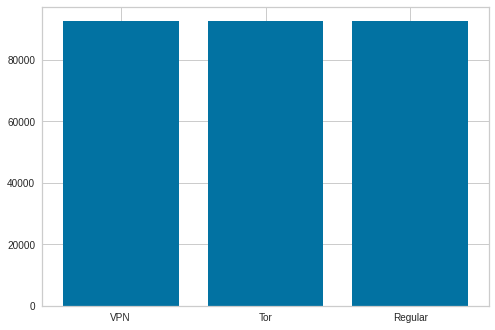

In [37]:
largest_class = get_largest_class_sample_size(traffic_dataset['Dataset'], 'Traffic Type')
ratio_dict = {"VPN": largest_class, "Regular": largest_class, "Tor": largest_class}
fake_df_traffic_majority_class = create_and_visualize_smote(utils.pd.concat([vpn_experiment_majority_class['Dataset'],tor_experiment_majority_class['Dataset'],regular_experiment_majority_class['Dataset']]),
                                                            'Traffic Type', ratio_dict)

### 30,000 Regular samples, 20,000 VPN, and 10,000 Tor

In [39]:
vpn_experiment_30_20_10 : utils.Model_data = create_and_filter_new_model(traffic_dataset, "Traffic Type", 'VPN')
tor_experiment_30_20_10 : utils.Model_data = create_and_filter_new_model(traffic_dataset, "Traffic Type", 'Tor')
regular_experiment_30_20_10 : utils.Model_data = create_and_filter_new_model(traffic_dataset, "Traffic Type", 'Regular')

regular_experiment_30_20_10['Dataset']  = downsample(regular_experiment_30_20_10['Dataset'], 'Traffic Type', 30000)
vpn_experiment_30_20_10['Dataset']  = downsample(vpn_experiment_30_20_10['Dataset'], 'Traffic Type', 20000)

Class=VPN, n=20000 (33.333%)
Class=Tor, n=10000 (16.667%)
Class=Regular, n=30000 (50.000%)


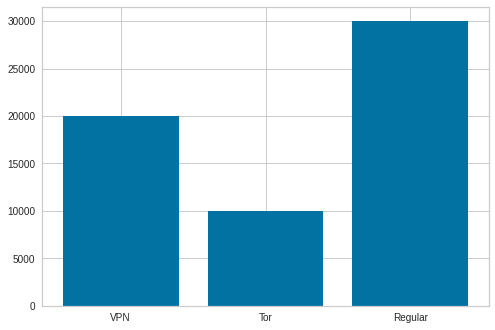

In [41]:
largest_class = get_largest_class_sample_size(traffic_dataset['Dataset'], 'Traffic Type')
ratio_dict = {"VPN": 20000, "Regular": 30000, "Tor": 10000}
fake_df_traffic_30_20_10 = create_and_visualize_smote(utils.pd.concat([vpn_experiment_30_20_10['Dataset'],tor_experiment_30_20_10['Dataset'],regular_experiment_30_20_10['Dataset']]),
                                                            'Traffic Type', ratio_dict)

In [55]:
fake_df_traffic_majority_class.to_csv('./synthetic/smote_traffic_upsample_to_majority.csv', index=False)
fake_df_traffic_30_20_10.to_csv('./synthetic/smote_traffic_30_20_10.csv', index=False)

# Synthetic Application Type Generation

In [54]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

def downsample_and_run_smote(dataset : dict, ratio_dict: dict, target_label: str) -> utils.pd.DataFrame:
    models : list = []
    df : utils.Dataframe = utils.pd.DataFrame()
    for key, value in ratio_dict.items():
        models.append(create_and_filter_new_model(dataset, target_label, key))
        if len(models[-1]['Dataset']) > value:
            models[-1]['Dataset'] = downsample(models[-1]['Dataset'], target_label, value)
        df = df.append(models[-1]['Dataset'])
    return create_and_visualize_smote(df, target_label, ratio_dict)

### Upsampling to the majority class

Class=audio-streaming, n=48020 (12.500%)
Class=browsing, n=48020 (12.500%)
Class=chat, n=48020 (12.500%)
Class=file-transfer, n=48020 (12.500%)
Class=email, n=48020 (12.500%)
Class=p2p, n=48020 (12.500%)
Class=video-streaming, n=48020 (12.500%)
Class=voip, n=48020 (12.500%)


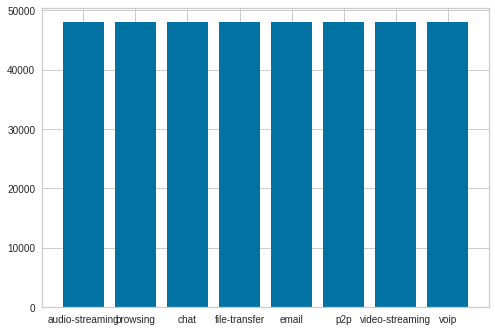

In [56]:
largest_class = get_largest_class_sample_size(application_dataset['Dataset'], 'Application Type')

fake_df_application_majority = downsample_and_run_smote(application_dataset, {"audio-streaming": largest_class, "browsing": largest_class, "chat": largest_class, "file-transfer": largest_class, "email": largest_class,
                                                                             "p2p": largest_class, "video-streaming": largest_class, "voip": largest_class}, 'Application Type')

fake_df_application_majority.to_csv('./synthetic/smote_application_upsample_to_majority.csv', index=False)

Class=audio-streaming, n=30000 (12.500%)
Class=browsing, n=30000 (12.500%)
Class=chat, n=30000 (12.500%)
Class=file-transfer, n=30000 (12.500%)
Class=email, n=30000 (12.500%)
Class=p2p, n=30000 (12.500%)
Class=video-streaming, n=30000 (12.500%)
Class=voip, n=30000 (12.500%)


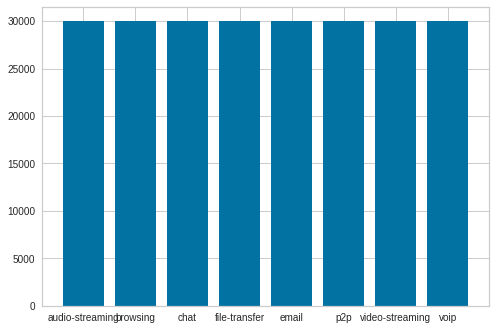

In [57]:
fake_df_application_30 = downsample_and_run_smote(application_dataset, {"audio-streaming": 30000, "browsing": 30000, "chat": 30000, "file-transfer": 30000, "email": 30000,
                                                                             "p2p": 30000, "video-streaming": 30000, "voip": 30000}, 'Application Type')

fake_df_application_30.to_csv('./synthetic/smote_application_30000.csv', index=False)

In [58]:
print(f'Last Execution: {utils.datetime.datetime.now()}')
assert False, 'Nothing after this point is included in the study'

Last Execution: 2022-04-10 12:27:32.974056


AssertionError: Nothing after this point is included in the study